# Aim

Turbulence screen generator that explicitly uses a generated basis, for easy modifications.

In [1]:
# imports

import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import convolve2d
from scipy.ndimage.measurements import center_of_mass
%matplotlib inline

In [2]:
# global parameter definitions

wavelength = 5e-7
dt    = 1/1000
T     = 1
D     = 10.95
r0    = 16.5e-2   
k     = 2 * np.pi / wavelength
p = 24
pupil_grid = make_pupil_grid(p, D)
times = np.arange(0, T, dt)
g = make_pupil_grid(p, diameter=D)
aperture = circular_aperture(D)(g)

In [3]:
modes = [i for i in range(1,3)] # 1 is tip 2 is tilt
basis = np.vstack([zernike(*ansi_to_zernike(i), D=D, grid=g) for i in modes]).T

In [4]:
outer_scale   = 20 
wind_velocity = 15
Cn2           = r0**(-5. / 3) / (0.423 * k**2)

def turbulence_phases():
    # returns a list of Fields representing the turbulence phases over time
    single_layer_atmos = InfiniteAtmosphericLayer(pupil_grid,  Cn_squared=Cn2, L0=outer_scale, 
                                                  velocity=wind_velocity, use_interpolation=True)
    single_layer_turb = [None] * times.size
    for n in range(times.size):
        single_layer_atmos.evolve_until(times[n])
        turb = single_layer_atmos.phase_for(wavelength)
        single_layer_turb[n] = Field(turb, grid=g) * aperture
    return single_layer_turb

In [5]:
phases = turbulence_phases()

In [6]:
# separate out TT
tt_phases = [None] * times.size
basis_t = basis.T
to_multiply = basis.dot(np.linalg.inv(basis_t.dot(basis)).dot(basis_t))
for i in range(times.size):
    tt_phases[i] = Field(to_multiply.dot(phases[i]), g)

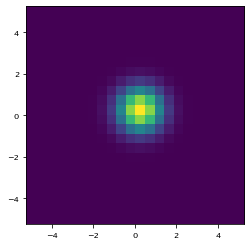

In [7]:
# make the object
def make_star(i, j, cutoff=1e-3, spread=5):
    center = g.shape//2
    intensity = np.exp(-np.sum((np.array([i, j]) - center)**2)/spread)
    if intensity > cutoff:
        return intensity
    return 0.0

star = Field(np.fromfunction(np.vectorize(make_star), g.shape).flatten(), g)
imshow_field(star)

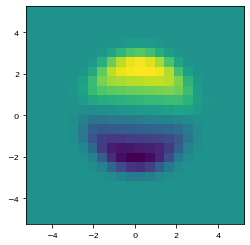

In [8]:
# aberrate
def convolve(f1, f2):
    assert isinstance(f1, Field)
    assert isinstance(f2, Field)
    assert np.all(f1.grid.shape == f2.grid.shape)
    convolved = convolve2d(np.reshape(f1, f1.grid.shape), np.reshape(f2, f2.grid.shape))[::2, ::2].flatten()
    return Field(convolved, f1.grid)
    
convolved_image = convolve(star, tt_phases[0])
imshow_field(convolved_image)

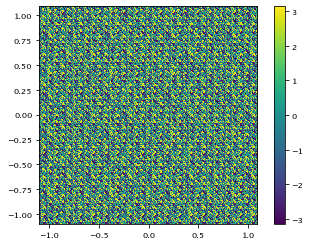

In [9]:
# propagate the dummy object through a phase screen
# don't know what any of these parameters should be

rad_to_mas = 1000 * 206265
number_lambdaOverD = wavelength / D

focal_grid = make_focal_grid_from_pupil_grid(g, q=rad_to_mas * number_lambdaOverD)
propagator = FraunhoferPropagator(g, focal_grid)
wf = Wavefront(convolved_image, wavelength)
detector_phase = propagator.forward(wf).phase
imshow_field(detector_phase)
plt.colorbar()

In [11]:
center_of_mass(np.array(detector_phase.reshape(focal_grid.shape)))

(-265.4582173944848, -472.7942830710083)

In [14]:
# now do all of this in a loop
conversion = 0.04
cm = np.zeros((times.size, 2))
for i in range(times.size):
    convolved_image = convolve(star, tt_phases[i])
    detector_phase = propagator.forward(Wavefront(convolved_image, wavelength)).phase
    cm[i] = center_of_mass(np.array(detector_phase.reshape(focal_grid.shape)))

cm *= conversion    
cm -= np.tile(np.mean(cm, axis=0), (times.size, 1))
cm = cm.T

Text(0.5, 1.0, 'Turbulence tip-tilt deviations')

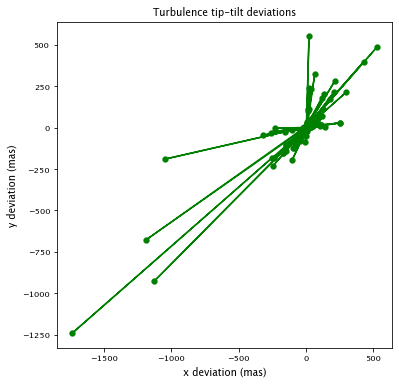

In [15]:
plt.figure(figsize=(6,6))
plt.plot(cm[0], cm[1], 'go-')
plt.xlabel("x deviation (mas)")
plt.ylabel("y deviation (mas)")
plt.title("Turbulence tip-tilt deviations")